In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.ma as ma

import healpy as hp
from lsst.sims.utils import _hpid2RaDec, _approx_RaDec2AltAz
from lsst.sims.utils import Site

from astropy.time import Time, TimeDelta
import lsst.sims.seeingModel as sm

from lsst.utils import getPackageDir

In [2]:
# Set up a SeeingModelConfig .. this could then be modified before passing to SeeingModel. 
conf = sm.SeeingModelConfig()
print(conf)

{'telescope_seeing': 0.25, 'optical_design_seeing': 0.08, 'camera_seeing': 0.3, 'raw_seeing_wavelength': 500.0, 'filter_list': ['u', 'g', 'r', 'i', 'z', 'y'], 'filter_effwavelens': [368.48, 480.2, 623.12, 754.17, 869.05, 973.64], 'throughputs_version': '1.5', 'efd_columns': ['FWHM_500'], 'efd_delta_time': 0.0, 'target_columns': ['airmass']}


In [3]:
# You can also check/update the effective wavelengths:
filters = ('u', 'g', 'r', 'i', 'z', 'y')
sims_photUtils_version, throughputs_version, effwavelens = sm.get_effwavelens(filters)
print(sims_photUtils_version, throughputs_version)
print(list(zip(filters, effwavelens)))

w.2019.10.1-2-g60d0775 1.5
[('u', 368.48332642306536), ('g', 480.19980829214086), ('r', 623.1199855290156), ('i', 754.1691936287622), ('z', 869.0469808767107), ('y', 973.6408690453528)]


In [4]:
# Example of updating these values
conf.filter_list = filters
conf.throughputs_version = throughputs_version
conf.filter_effwavelens = effwavelens

In [5]:
# Set up and configure the SeeingModel. (note that configure with no kwarg will just use defaults, as above)
seeingModel = sm.SeeingModel(conf)   #  equivalent to seeingModel = sm.SeeingModel() when using defaults

In [6]:
# Dump the config properties and version info.
seeingModel.config_info()

OrderedDict([('SeeingModel_version', 'unknown'),
             ('SeeingModel_sha', '9c227f867ba771bd4c66fa36de37e3bafb93a1a9 *'),
             ('telescope_seeing', 0.25),
             ('optical_design_seeing', 0.08),
             ('camera_seeing', 0.3),
             ('raw_seeing_wavelength', 500.0),
             ('filter_list', ['u', 'g', 'r', 'i', 'z', 'y']),
             ('filter_effwavelens',
              [368.48332642306536, 480.19980829214086, 623.1199855290156, 754.1691936287622, 869.0469808767107, 973.6408690453528]),
             ('throughputs_version', '1.5'),
             ('efd_columns', ['FWHM_500']),
             ('efd_delta_time', 0.0),
             ('target_columns', ['airmass'])])

In [7]:
# Find the values the SeeingModel wants from the EFD. 
cols, deltaT = seeingModel.efd_requirements
print(cols, deltaT)
# Find the columns the SeeingModel wants in its input map (over which to calculate the seeing values)
print(seeingModel.target_requirements)

['FWHM_500'] 0.0
['airmass']


In [8]:
# Set up to get seeingData from db..  (this is where EFD would step in, in the future)
t = Time('2002-01-01', scale='utc', format='isot')

# setting seeing_db = None will use the default. 
# Here we will specify what is currently the default, as an example of how to set the value.
seeing_db = os.path.join(getPackageDir('SIMS_SEEINGMODEL'), 'data', 'simsee_pachon_58777_13.db')

# Set up the seeingData
seeingData = sm.SeeingData(t, seeing_db=seeing_db)
seeingData.read_data()

In [11]:
# Take a peek at the FWHM_500 values throughout the lifetime of the survey. 

t_end = (3650) * 24 * 60 * 60  # seconds
t_step = 1 * 24 * 60 * 60
times = np.arange(0, t_end + t_step/2, t_step)
fwhm_500 = np.zeros(len(times), float)
for i, t_add in enumerate(times):
    t_now = t + TimeDelta(t_add, format='jd')
    fwhm_500[i] = seeingData(t_now)

Text(0, 0.5, 'FWHM_500')

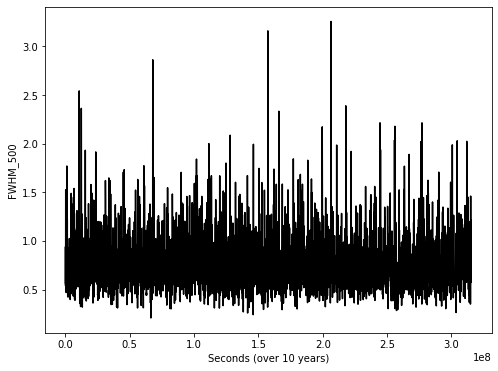

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(times, fwhm_500, 'k-')
plt.xlabel('Seconds (over 10 years)')
plt.ylabel('FWHM_500')

Text(0, 0.5, 'Airmass')

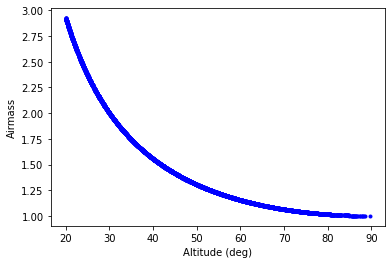

In [13]:
# Set up grid around sky .. (places we'd be likely to calculate the FWHM_eff in the FBS)
lsst_site = Site('LSST')
nside = 32
hpid = np.arange(hp.nside2npix(nside))
ra, dec = _hpid2RaDec(nside, hpid)
alt, az = _approx_RaDec2AltAz(ra, dec, lsst_site.latitude_rad, lsst_site.longitude_rad, t.mjd)

# Set up a mask so that we only calculate airmass (and seeing) where it's visible.
# This is faster than using explicit masked arrays.
mask = np.where(alt < np.radians(20), True, False)
visible = np.where(alt > np.radians(20))
airmass = 1./np.cos(np.pi/2. - alt)

plt.plot(np.degrees(alt[visible]), airmass[visible], 'b.')
plt.xlabel('Altitude (deg)')
plt.ylabel('Airmass')

In [16]:
%%timeit 
# Full calculation
airmass = 1./np.cos(np.pi/2. - alt)

92.7 µs ± 5.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
altM = ma.MaskedArray(data=alt, mask=mask, fill_value=0)
airmassM = 1./np.cos(np.pi/2. - altM)

In [18]:
%%timeit  
# Calculation with masked arrays ... this is much slower.
airmassM = 1./np.cos(np.pi/2. - altM)

346 µs ± 8.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
airmass = np.zeros(len(alt), float)

In [15]:
%%timeit
# calculation with mask, although making 'airmass' array each time.
airmass[visible] = 1./np.cos(np.pi/2. - alt[visible])

55.5 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
fwhm_500 = seeingData(t_now)
print(fwhm_500)

1.2106643542178421


In [20]:
# Put input telemetry and target map into dictionaries:
mapDict = {'airmass': airmass}
mapDictMask = {'airmass': airmass[visible]}
efdDict = {'FWHM_500': fwhm_500}

In [21]:
%%timeit
# Check time to calculate seeing. No mask. 
modelDict = seeingModel(efdDict, mapDict)
fwhm_eff = modelDict['fwhmEff']
fwhm_geom = modelDict['fwhmGeom']

892 µs ± 50.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
%%timeit
# Check time to calculate seeing. WITH mask.
fwhm_eff = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
fwhm_geom = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
#print(fwhm_eff[:, visible[0]].shape)
modelDict = seeingModel(efdDict, mapDictMask)
fwhm_eff[:, visible[0]] = modelDict['fwhmEff']
fwhm_geom[:, visible[0]] = modelDict['fwhmGeom']

551 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
# And then what about time, if you pre-allocate arrays?
fwhm_eff = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
fwhm_geom = np.zeros((len(seeingModel.filter_list), len(airmass)), float)

In [24]:
%%timeit
modelDict = seeingModel(efdDict, mapDictMask)
fwhm_eff[:, visible[0]] = modelDict['fwhmEff']
fwhm_geom[:, visible[0]] = modelDict['fwhmGeom']

506 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
# Loop over a bunch of times and calculate values.. (maybe what you'd do in the driver)
t_end = 10 * 60 * 60  # seconds
t_step = 30 # seconds
times = np.arange(0, t_end + t_step/2, t_step)
fwhm_500 = np.zeros(len(times), float)
fwhm_eff = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
fwhm_geom = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
for i, t_add in enumerate(times):
    t_now = t + TimeDelta(t_add, format='jd')
    fwhm_500[i] = seeingData(t_now)
    modelDict = seeingModel({'FWHM_500': fwhm_500[i]}, mapDictMask)
    fwhm_eff[:, visible[0]] = modelDict['fwhmEff']
    fwhm_geom[:, visible[0]] = modelDict['fwhmGeom']

In [26]:
for f, fwhmEff in zip(seeingModel.filter_list, fwhm_eff):
    print(f, fwhmEff[visible])

u [1.53940787 1.52421421 1.51349541 ... 1.23801007 1.26166602 1.22099697]
g [1.46076516 1.44634769 1.43617648 ... 1.17476467 1.19721213 1.15862071]
r [1.39124138 1.3775101  1.36782298 ... 1.11885282 1.14023191 1.10347722]
i [1.34489528 1.33162142 1.322257   ... 1.08158073 1.10224762 1.06671733]
z [1.31282855 1.29987118 1.29073004 ... 1.05579229 1.07596641 1.04128328]
y [1.28850777 1.27579045 1.26681865 ... 1.03623323 1.05603362 1.02199301]
